# Beat the bookie


## Executive summary
The technical test has provided a research paper called "Beating the bookies with their own numbers - and
how the online sports betting market is rigged" and the corresponding dataset.
The key objectives are:
- Understanding the topic and approach
- Explore the given dataset
- Create a model that will predict whether a football match will be selected by the betting strategy outlined in the article **before the odds are known**

The dataset contains information about matches from 2005 to 2015, across different leagues, bookmakers and odds.

## Short summary of the article
The article describes a strategy to win against the bookmakers by using the inefficiencies in the odds provided by them. 
Bookmakers price odds such that the implied probabilites are more than 100%, which is the margin that is profitable for them.
The authors in the article use the probability information implicit in the odds from the bookmakers to find bets with mispriced odds.

In [6]:
import os
import pandas as pd
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [8]:
with gzip.open('../data/closing_odds.csv', 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f)
    

In [3]:
df['match_date'] = pd.to_datetime(df['match_date'])

In [4]:
print(f"Number of unique matches: {df['match_id'].nunique()}")

Number of unique matches: 479440


### Matches per League
The bar chart shows the number of matches across the top 20 leagues. The biggest league in the dataset is World: Club Friendly and different English, French, Spanish and Italian are also quite represented.

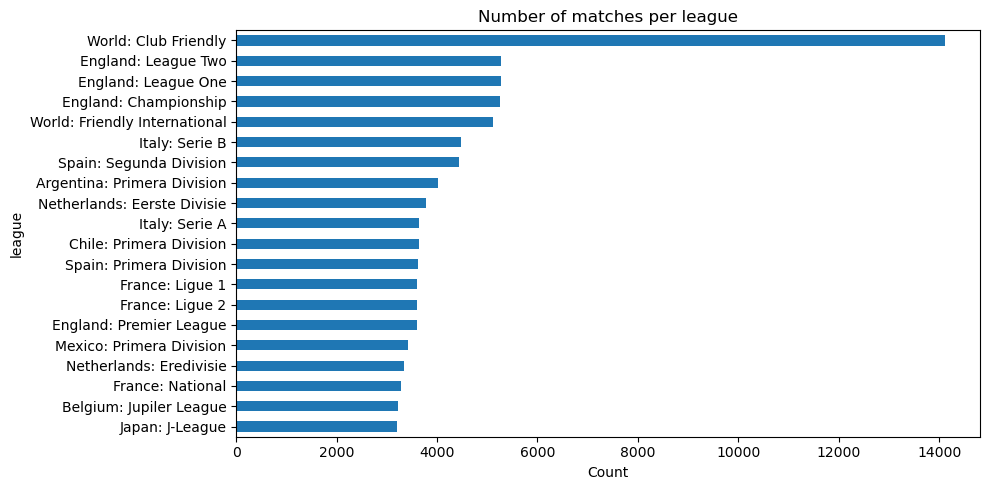

In [5]:
matches_per_league = df['league'].value_counts().sort_values(ascending=False)
matches_per_league = matches_per_league[:20].sort_values(ascending=True) # dont need all 880 for visualization

matches_per_league.plot(kind='barh', title = 'Number of matches per league', figsize=(10,5))
plt.xlabel('Count')
plt.tight_layout()
plt.show()


### Histogram of Average odds
The histograms for the average odds for home win, draw and away win show that all the distributions are positively skewed.
It can be seen how the home win odds are all concentrated at lower values compared to draws and away wins, meaning bookmakers favor the home team, as expected.

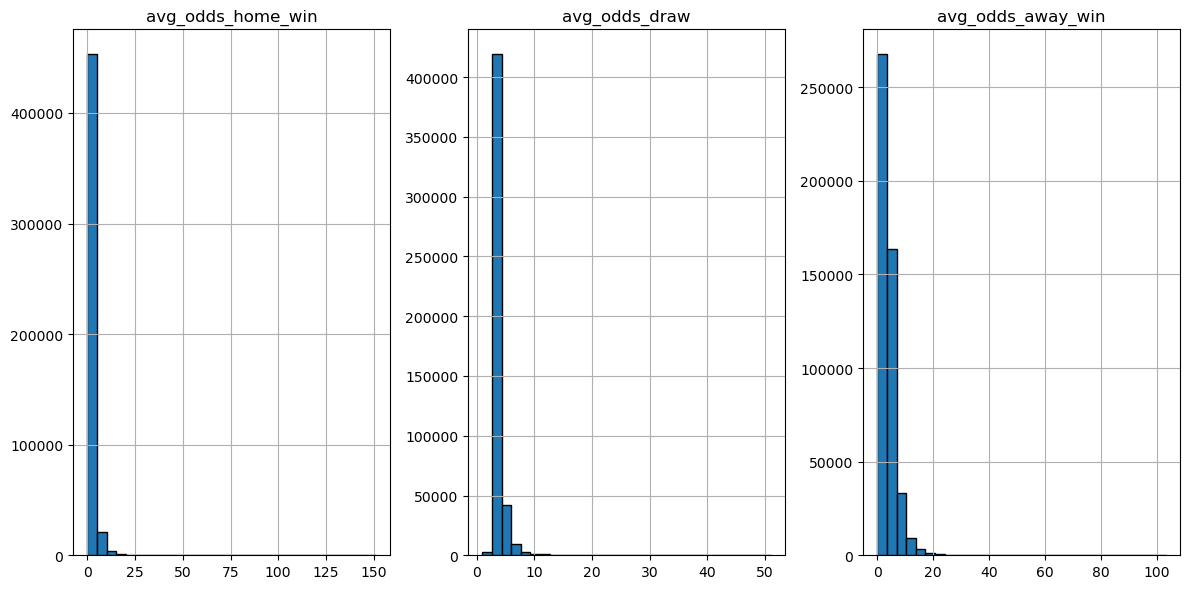

In [6]:
odds_columns = ['avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win']
df[odds_columns].hist(bins=30, figsize=(12,6), layout=(1,3), edgecolor = 'black')
plt.tight_layout()
plt.show()

### Odds distributions
The odds distribution for two leagues are compared: English Premier League and Spanish Primera Divison (La Liga).
Both seem to be quite similar, home wins have lowest average odds, while draw and away odds are higher.

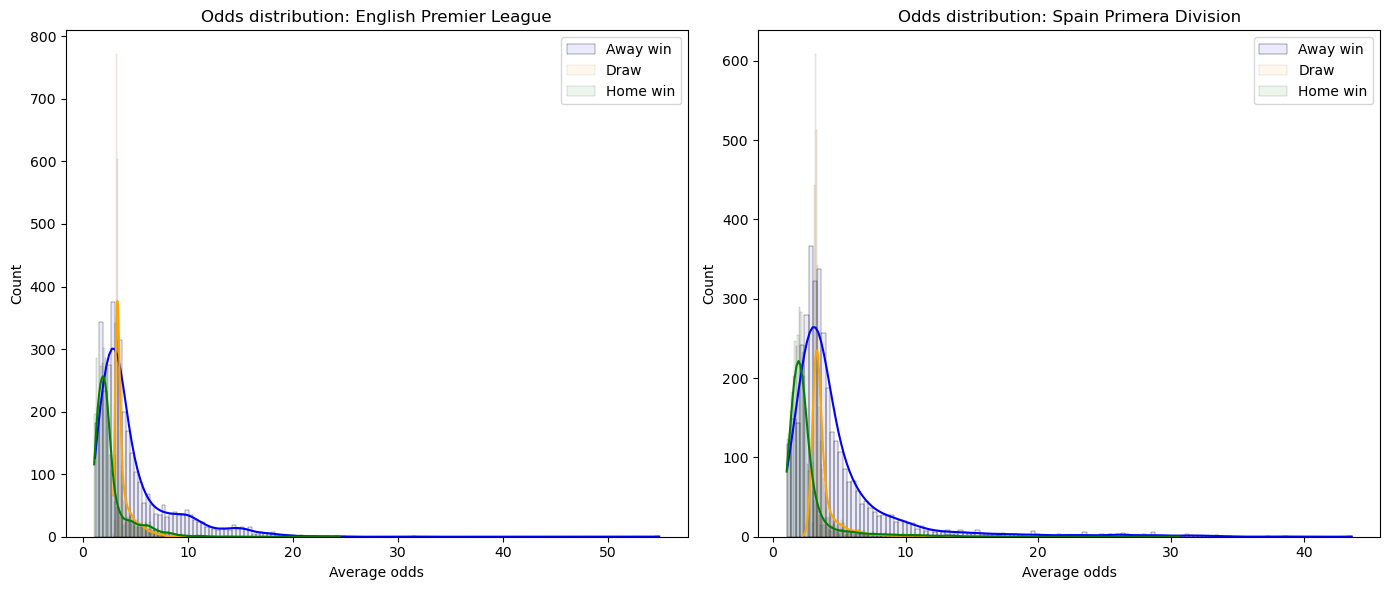

In [7]:
epl_df = df[df['league'] == 'England: Premier League']
la_df = df[df['league'] == 'Spain: Primera Division']

fig, axes = plt.subplots(1, 2, figsize = (14,6))

sns.histplot(epl_df['avg_odds_away_win'], kde = True, color='blue', label = 'Away win', ax=axes[0], alpha=0.08)
sns.histplot(epl_df['avg_odds_draw'], kde = True, color='orange', label = 'Draw', ax=axes[0], alpha=0.08)
sns.histplot(epl_df['avg_odds_home_win'], kde = True, color='green', label = 'Home win', ax=axes[0], alpha=0.08)
axes[0].set_title('Odds distribution: English Premier League')
axes[0].set_xlabel('Average odds')
axes[0].legend()

sns.histplot(la_df['avg_odds_away_win'], kde = True, color='blue', label = 'Away win', ax=axes[1], alpha=0.08)
sns.histplot(la_df['avg_odds_draw'], kde = True, color='orange', label = 'Draw', ax=axes[1], alpha=0.08)
sns.histplot(la_df['avg_odds_home_win'], kde = True, color='green', label = 'Home win', ax=axes[1], alpha=0.08)
axes[1].set_title('Odds distribution: Spain Primera Division')
axes[1].set_xlabel('Average odds')
axes[1].legend()

plt.tight_layout()
plt.show()

### Top bookmakers
**Pinnacle Sports**, **bet365** and **bwin** are leading the chart, which probably means they are covering the most number of matches suggesting their big market share.

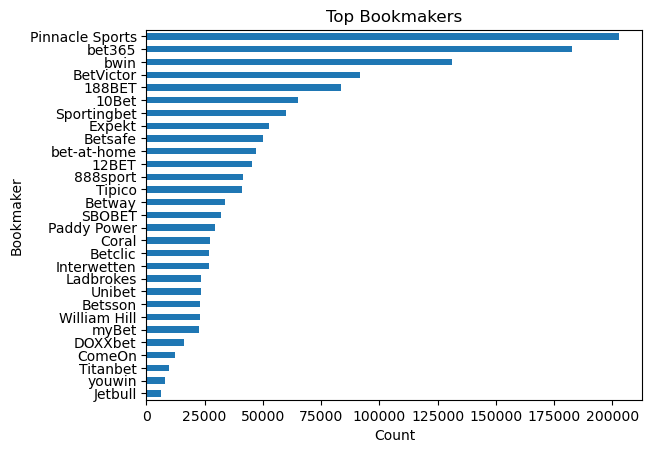

In [8]:
top_bookie_counts = df[['top_bookie_home_win', 'top_bookie_draw', 'top_bookie_away_win']].melt(
    value_name='bookmaker', var_name='outcome')['bookmaker'].value_counts().sort_values(ascending=True)

top_bookie_counts.plot(kind='barh', title='Top Bookmakers')
plt.ylabel('Bookmaker')
plt.xlabel('Count')
plt.show()


### Average odds across leagues
Comparing the average odds across the top 10 leagues, we can see the same patterns in all - average odds for home win are the lowest, for away win are highest and draw is in the middle except in World: Club Friendly.
World: Club Friendly and World: Friendly International have higher odds in all outcomes, which is and indication for a greater unpredictability in the friendly matches.

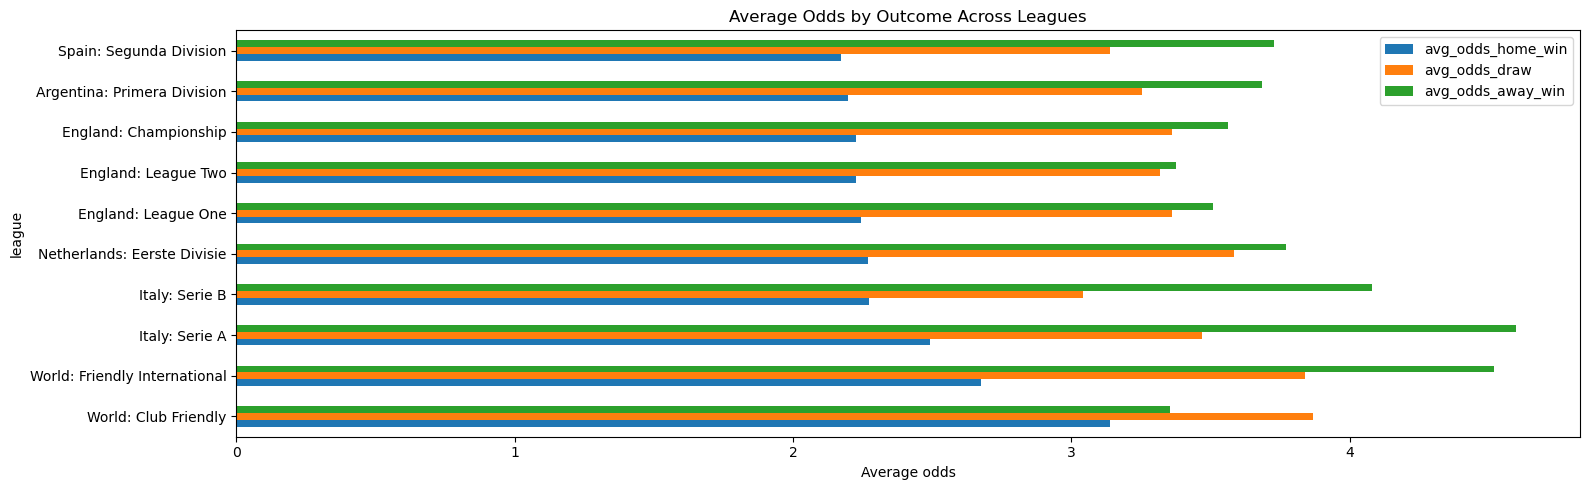

In [9]:
avg_odds_by_league = df.groupby('league')[['avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win']].mean()
avg_odds_by_league = avg_odds_by_league[avg_odds_by_league.index.isin(matches_per_league.sort_values(ascending=False).head(10).index)]

avg_odds_by_league = avg_odds_by_league.sort_values(by = ['avg_odds_home_win','avg_odds_draw','avg_odds_away_win'], ascending=False)

avg_odds_by_league.plot(kind='barh', title= 'Average Odds by Outcome Across Leagues', figsize=(16,5))
plt.xlabel('Average odds')
plt.tight_layout()
plt.show()


### Home versus Away
As expected home advantage is evident.

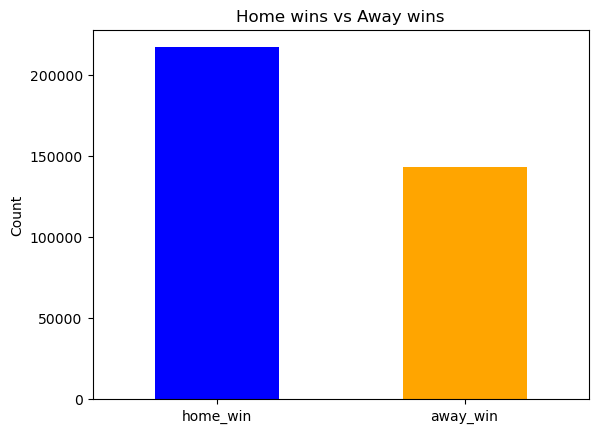

In [10]:
df['home_win'] = (df['home_score'] > df['away_score']).astype(int)
df['away_win'] = (df['home_score'] < df['away_score']).astype(int)
df['draw'] = (df['home_score'] == df['away_score']).astype(int)

home_away_wins = df[['home_win', 'away_win']].sum()
home_away_wins.plot(kind='bar', title='Home wins vs Away wins', color=['blue', 'orange'])
plt.ylabel('Count')
plt.xticks(rotation=0, ha='center')
plt.show()

Now, inspecting how the home versus away wins change over time, it can be seen that home wins remain quite higher than away wins, with a win percentage of ~45%.
The away wins seem to have slight upward trend increasing to about 30%, gradually decreasing the gap between the two.

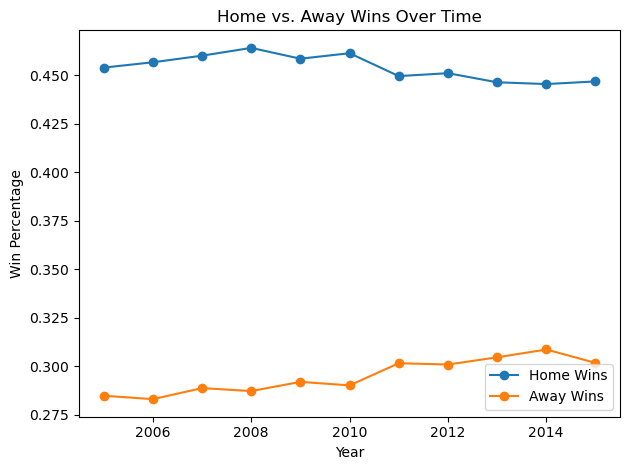

In [11]:
home_away_trend = df.groupby(df['match_date'].dt.year)[['home_win', 'away_win']].mean()

home_away_trend.plot(marker='o')
plt.title('Home vs. Away Wins Over Time')
plt.xlabel('Year')
plt.ylabel('Win Percentage')
plt.legend(['Home Wins', 'Away Wins'])
plt.tight_layout()
plt.show()

In [12]:
df['prob_home_win'] = 1 / df['avg_odds_home_win']
df['prob_draw'] = 1 / df['avg_odds_draw']
df['prob_away_win'] = 1 / df['avg_odds_away_win']

df['correct_pred'] = (
    (df['home_win'] & (df['prob_home_win'] > df['prob_draw']) & (df['prob_home_win'] > df['prob_away_win'])) | 
    (df['away_win'] & (df['prob_away_win'] > df['prob_draw']) & (df['prob_away_win'] > df['prob_home_win'])) |
    ((df['home_win'] == 0) & (df['away_win'] == 0) & (df['prob_draw'] > df['prob_home_win']) & (df['prob_draw'] > df['prob_away_win']))
).astype(int)


### Bookmaker accuracy
The same general trends are observed, home wins have highest accuracy across all bookmakers. Draws have the lowest accuracy, as expected given their high uncertainty. Away wins have more varying accuracy.
It can be clearly seen, that some bookmakers perform much better than others. Reasons for that could be better models, better data.

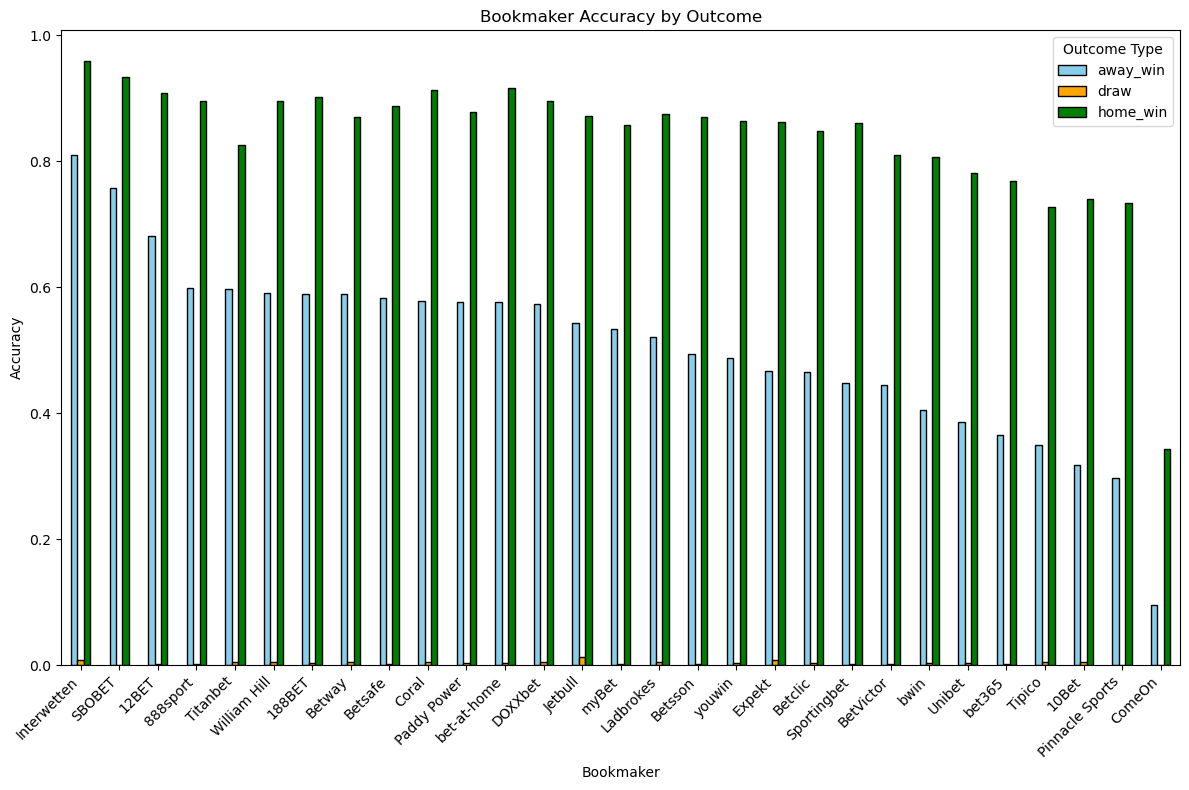

In [13]:
bookmakers = pd.melt(df, 
                     id_vars=['correct_pred', 'home_win', 'draw', 'away_win'],
                     value_vars=['top_bookie_home_win', 'top_bookie_draw', 'top_bookie_away_win'],
                     var_name = 'Outcome type',
                     value_name='Bookmaker'
)

bookmakers['Outcome type'] = bookmakers['Outcome type'].map({
    'top_bookie_home_win': 'home_win',
    'top_bookie_draw': 'draw',
    'top_bookie_away_win': 'away_win'
})

bookmaker_accuracy = bookmakers.groupby(['Bookmaker', 'Outcome type']).apply(lambda x: pd.Series({
    'Outcome accuracy': x.loc[x[x['Outcome type'].iloc[0]] == 1, 'correct_pred'].mean()
})).reset_index()

bookmaker_plot = bookmaker_accuracy.pivot(index='Bookmaker', columns='Outcome type', values='Outcome accuracy')

bookmaker_plot = bookmaker_plot.sort_values(by=['away_win', 'draw', 'home_win'], ascending=False)

bookmaker_plot.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange', 'green'], edgecolor='black')

plt.title('Bookmaker Accuracy by Outcome')
plt.ylabel('Accuracy')
plt.xlabel('Bookmaker')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Outcome Type')
plt.tight_layout()
plt.show()

### Odds over time
The overall trends for all three types are relatively stable over time. There are seasonal spikes each year, which might correspond to seasons in the leagues.
The gaps between the three types of odds, show that the bookmakers' probabilities have not changed much over the years.

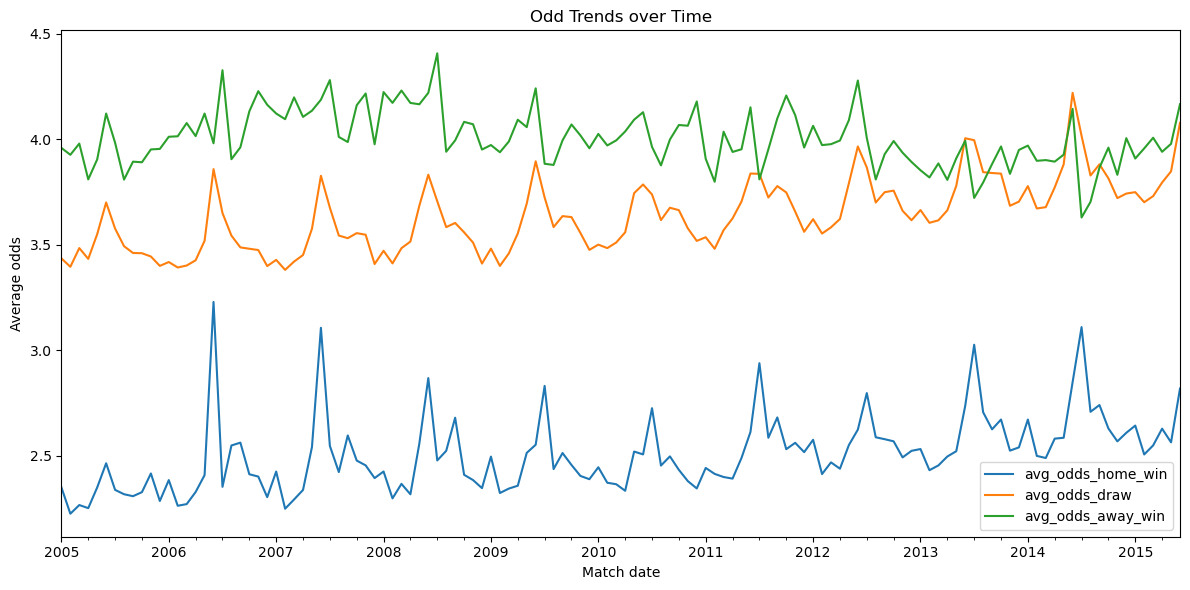

In [14]:
df['match_date'] = pd.to_datetime(df['match_date'])

odds_trend = df.set_index('match_date').resample('M')[['avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win']].mean()

odds_trend.plot(figsize=(12,6), title = 'Odd Trends over Time')
plt.xlabel('Match date')
plt.ylabel('Average odds')
plt.tight_layout()
plt.show()

### Histograms of probabilites
The graphs show the distribution of probabilites for the outcomes. The home wins, have a wide range with center around 0.5, indicating yet again the home advantage. The draws are narrowly distributed between 0.2 and 0.3.
The away wins are skewed to the right, with center around 0.2 to 0.4. This highlights the bookmakers bias towards home teams and the more stable probabilites of draws.


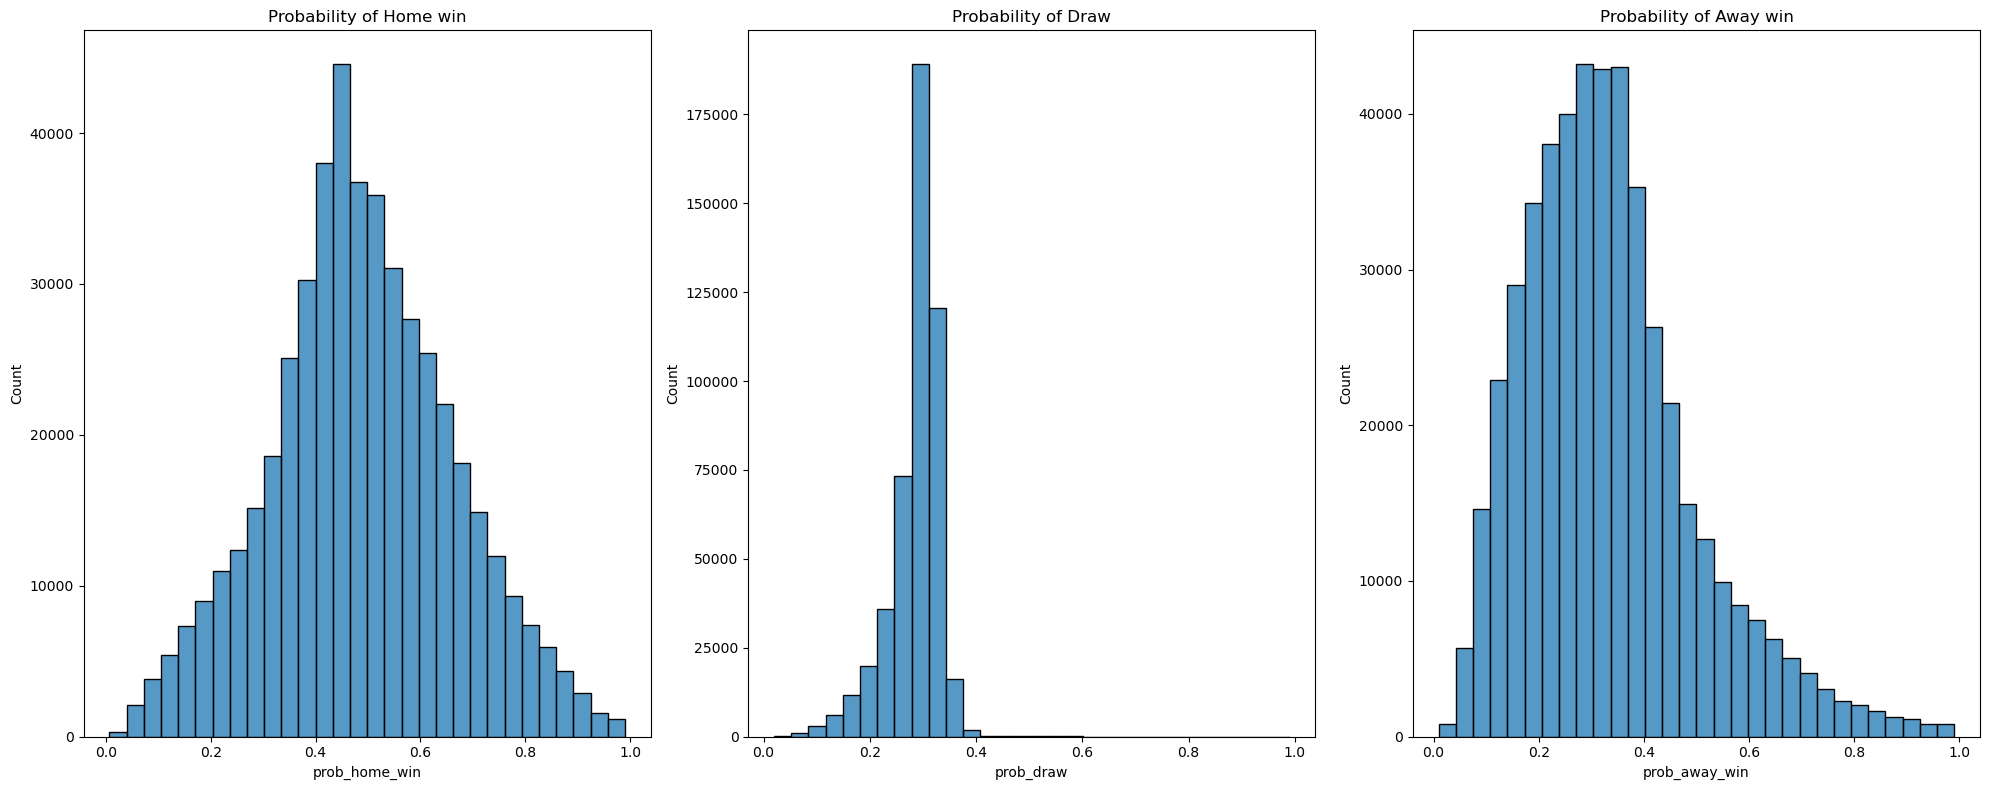

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
sns.histplot(df['prob_home_win'], bins = 30, ax=ax1)
ax1.set_title('Probability of Home win')
sns.histplot(df['prob_draw'], bins = 30, ax = ax2)
ax2.set_title('Probability of Draw')
sns.histplot(df['prob_away_win'], bins = 30, ax = ax3)
ax3.set_title('Probability of Away win')

plt.tight_layout()
plt.show()

## Beat the bookie strategy

The implementation and logic of the strategy, was inspired by the notebook: https://www.kaggle.com/code/sashchernuh/reproduce-of-winning-strategy-refactored. I used that logic, since the usage of only equation 7 ($\max(\Omega) > \frac{1}{p_{\text{cons}} - 0.05}$), was not enough accurate in regards to the article. The equation 5 is used to calculate the expected payoff:

$E(\Pi) \simeq (p_{\text{cons}} - \alpha) \cdot \omega - 1$

In the article, 56435 matches are valid for betting, while using only equation 7, I got 58348 matches valid. So, in order to be in compliance with the article I used the logic from the notebook I found on Kaggle, just made it simpler.

In [16]:
home_condition = df['n_odds_home_win'] > 3
draw_condition = df['n_odds_draw'] > 3
away_condition = df['n_odds_away_win'] > 3

df['home_margin'] = ((df['prob_home_win'] - 0.05) * df['max_odds_home_win'] - 1) * home_condition

df['draw_margin'] = ((df['prob_draw'] - 0.05) * df['max_odds_draw'] - 1) * draw_condition

df['away_margin'] = ((df['prob_away_win'] - 0.05) * df['max_odds_away_win'] - 1) * away_condition

df['max_margin'] = df[['home_margin', 'draw_margin', 'away_margin']].max(axis=1)
df['max_outcome'] = df[['home_margin', 'draw_margin', 'away_margin']].idxmax(axis=1)

df['valid_bet'] = df['max_margin'] > 0

In [17]:
print(df['valid_bet'].value_counts())

valid_bet
False    423005
True      56435
Name: count, dtype: int64


Using only eq.7:
$\max(\Omega) > \frac{1}{p_{\text{cons}} - 0.05}$

And the condition that the number of odds should be bigger than 3.

In [18]:
df['valid_bet_2'] = np.where(
    ((df['max_odds_home_win'] > 1 / (df['prob_home_win'] - 0.05)) & (df['n_odds_home_win'] > 3)) | 
    ((df['max_odds_draw'] > 1 / (df['prob_draw'] - 0.05)) & (df['n_odds_draw'] > 3)) | 
    ((df['max_odds_away_win'] > 1 / (df['prob_away_win'] - 0.05)) & (df['n_odds_away_win'] > 3)),
    1,
    0
)

In [19]:
print(df['valid_bet_2'].value_counts())

valid_bet_2
0    421092
1     58348
Name: count, dtype: int64


## Prediction

In [20]:
home_matches = df.groupby('home_team').size()
away_matches = df.groupby('away_team').size()
total_matches = home_matches.add(away_matches, fill_value=0)
average_matches_per_team = total_matches.mean()
print(f'Average matches per team: {average_matches_per_team: .2f}')

Average matches per team:  86.89


The features are created by calculating rolling averages for team performance over the last 40 matches as it gives us information on how the team's play improves or declines with time. It includes metrics like average goals scored, goals taken, win, draw and loss rates. Additionaly, win and draw rates are computed on league-level. Also, categorical feature is created, which segments the matches into early, mid or late in the season.
Several different number of matches were tested for the window parameter, from 3 to 40, and it seems that increasing the window, the AUC score is slightly increasing.

In [21]:
df = df.sort_values(['home_team', 'match_date'])
df['avg_goals_home'] = (
    df.groupby('home_team')['home_score'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['avg_goals_taken_home'] = (
    df.groupby('home_team')['away_score'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['win_rate_home'] = (
    df.groupby('home_team')['home_win'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['draw_rate_home'] = (
    df.groupby('home_team')['draw'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['loss_rate_home'] = (
    df.groupby('home_team')['away_win'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df = df.sort_values(['away_team', 'match_date'])

df['avg_goals_away'] = (
    df.groupby('away_team')['away_score'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['win_rate_away'] = (
    df.groupby('away_team')['away_win'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['draw_rate_away'] = (
    df.groupby('away_team')['draw'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['loss_rate_away'] = (
    df.groupby('away_team')['home_win'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['avg_goals_taken_away'] = (
    df.groupby('away_team')['home_score'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df = df.sort_values(['league', 'match_date'])
df['league_avg_win_rate_home'] = (
    df.groupby('league')['home_win'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)
df['league_avg_draw_rate'] = (
    df.groupby('league')['draw'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)
df['league_avg_win_rate_away'] = (
    df.groupby('league')['away_win'].rolling(window=40, min_periods=1).mean().reset_index(0, drop=True)
)

df['season_part'] = df['match_date'].dt.month.apply(lambda x: 'early' if x < 5 else 'late' if x > 8 else 'mid')

df = pd.get_dummies(df, columns=['season_part'])

In [22]:
df = df.sort_values(by = 'match_date')
split_date = df['match_date'].quantile(0.7)

train_df = df[df['match_date'] <= split_date]
test_df = df[df['match_date'] > split_date]


features = ['avg_goals_home', 'avg_goals_taken_home', 'win_rate_home', 'draw_rate_home', 'loss_rate_home', 'avg_goals_away',
            'win_rate_away', 'avg_goals_taken_away', 'draw_rate_away', 'loss_rate_away', 
            'league_avg_win_rate_home', 'league_avg_draw_rate', 'league_avg_win_rate_away', 
            'season_part_early', 'season_part_late', 'season_part_mid']

X_train = train_df[features]
y_train = train_df['valid_bet']

X_test = test_df[features]
y_test = test_df['valid_bet']

In [23]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [25]:
auc = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc:.3f}")

AUC Score: 0.517


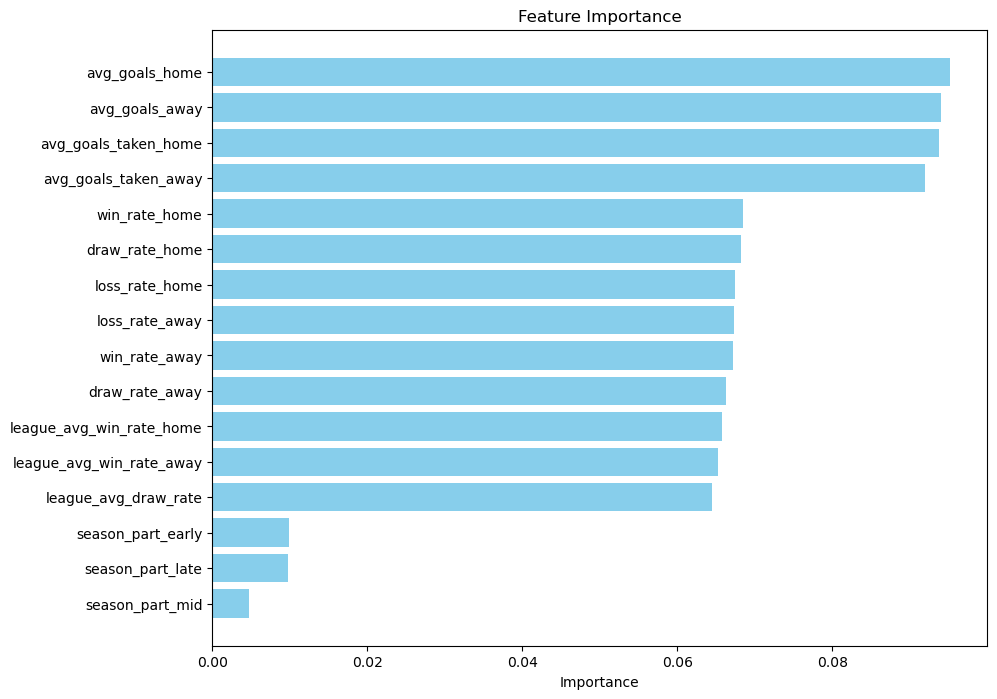

In [26]:
features = X_train.columns
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)
sorted_features = features[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# Conclusion

Random Forest Classifier was used as a quick baseline model, as it gives fast and reliable results. It also has built in feature importance, which could give additional insights.
This is a very basic implementation of a model, which could be greatly improved by getting better features, more data, tuning the hyperparameters, choosing a different more advanced models.

**Model performance**: 
The AUC score was 0.517, which is only a very little better than random guessing. This means that the current features and model do not capture the patterns and doesn't differentiate well between valid and invalid bets.